# Question 1

In [172]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import pandas as pd
import numpy as np

In [173]:
# 1
data = pd.read_csv("compustat.zip")[["sic","datacqtr","cusip","cshoq","saleq","prccq"]]
data["mktcap"] = data["cshoq"] * data["prccq"]
data.head(5)

,sic,datacqtr,cusip,cshoq,saleq,prccq,mktcap
0,3089.0,1966Q1,000032102,0.219,NaN,NaN,NaN
1,3089.0,1966Q2,000032102,0.219,NaN,NaN,NaN
2,3089.0,1966Q3,000032102,0.219,NaN,NaN,NaN
3,3089.0,1966Q4,000032102,0.219,4.032,NaN,NaN
4,3089.0,1967Q1,000032102,0.277,NaN,NaN,NaN


In [174]:
# 2
saleq_mean = data["saleq"].dropna().mean()
mktcap_mean = data["mktcap"].dropna().mean()

saleq_sd = data["saleq"].dropna().std()
mktcap_sd = data["mktcap"].dropna().std()

saleq_miss = data["saleq"].isna().sum()
mktcap_miss = data["mktcap"].isna().sum()

saleq_ratio = saleq_miss / data.shape[0]
mktcap_ratio = mktcap_miss / data.shape[0]

In [175]:
result = [[saleq_mean, mktcap_mean],
          [saleq_sd, mktcap_sd],
          [saleq_miss, mktcap_miss],
          [saleq_ratio, mktcap_ratio]]
result = pd.DataFrame(result,
                      index = ["mean", "sd", "count(missing)", "missing ratio"],
                      columns = ["saleq", "mktcap"])
result

,saleq,mktcap
mean,445.150664,2057.473104
sd,2679.706576,13202.197457
count(missing),269498.000000,468276.000000
missing ratio,0.148787,0.258530


In [176]:
# 3
# we can plot boxplots to detect outliers
import matplotlib.pyplot as plt
import seaborn as sns

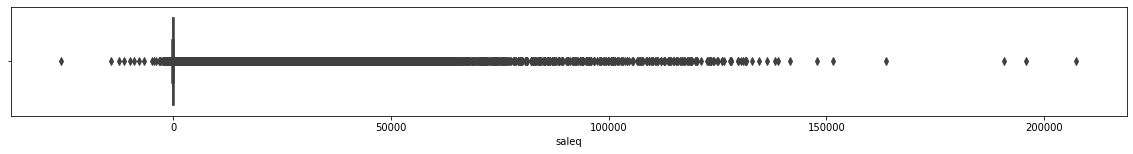

In [177]:
plt.figure(figsize=(20,2))
sns.boxplot(data['saleq'])

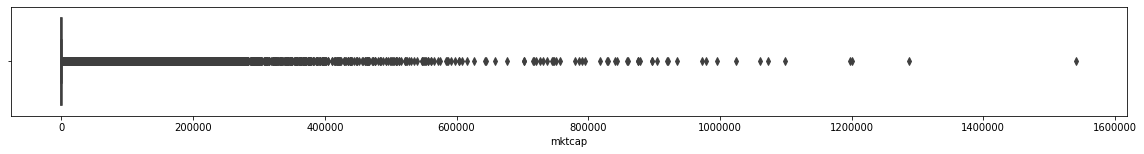

In [178]:
plt.figure(figsize=(20,2))
sns.boxplot(data['mktcap'])

In [179]:
# We could see there are some outliers for saleq and mktcap.
# To analyze the data properly, we may need to seperate the data i
# into different groups based on other indicators, such as sic and 
# prccq.

# Question 2

In [199]:
data.HHI = pd.DataFrame(data,columns=["sic","datacqtr","mktcap"]).dropna()
data.HHI = data.HHI.groupby(['sic','datacqtr'],as_index=False).sum()
# 2 digits sic code
data.HHI["sic"] = (data.HHI["sic"]%100)

# sum of mktcap
sumcap = data.HHI.groupby(['datacqtr','sic'])['mktcap'].sum().reset_index()
sumcap.rename(columns={'mktcap':'sumcap'},inplace=True)

# merge data.HHI & sumcap
data.HHI = pd.merge(data.HHI,sumcap,on=["datacqtr","sic"])

# HHI
data.HHI["HHI"] = pow(((data.HHI["mktcap"]/data.HHI["sumcap"])*100),2)
industryHHI = data.HHI.groupby(["datacqtr","sic"])["HHI"].sum().reset_index()
industryHHI.rename(columns={"HHI":"HHI_index"},inplace= True)

# merge data.HHI & industryHHI
data.HHI = pd.merge(data.HHI,industryHHI,on=["datacqtr","sic"])
data.HHI.head()

,sic,datacqtr,mktcap,sumcap,HHI,HHI_index
0,0.0,1967Q4,65.205000,2588.303642,6.346457,1797.328226
1,0.0,1967Q4,995.809856,2588.303642,1480.206797,1797.328226
2,0.0,1967Q4,77.490500,2588.303642,8.963270,1797.328226
3,0.0,1967Q4,226.074250,2588.303642,76.290727,1797.328226
4,0.0,1967Q4,26.753750,2588.303642,1.068412,1797.328226


In [206]:

HHI_mean = data.HHI.groupby(['sic'])['HHI_index'].mean().reset_index()
HHI_mean = HHI_mean[HHI_mean['HHI_index'] < 10000]
HHI_mean.sort_values(by='HHI_index', ascending=False, inplace=True)
HHI_top4_sic = [HHI_mean.iloc[i, 0] for i in range(4)]
HHI_top4_sic

[98.0, 64.0, 77.0, 97.0]

In [201]:
HHI_top4 = pd.DataFrame(data.HHI, columns=['datacqtr', 'sic', 'HHI_index'])
HHI_top4 = HHI_top4[HHI_top4['sic'].isin(HHI_top4_sic)]
HHI_top4.drop_duplicates(inplace=True)

HHI_top4.reset_index(drop=True, inplace=True)
HHI_top4['datacqtr'] = pd.to_datetime(HHI_top4['datacqtr'].str[:4] + HHI_top4['datacqtr'].str[4:6])
HHI_top4.head()


,datacqtr,sic,HHI_index
0,1968-10-01,64.0,10000.0
1,1969-01-01,64.0,10000.0
2,1969-04-01,64.0,10000.0
3,1969-07-01,64.0,10000.0
4,1969-10-01,64.0,10000.0


In [208]:
time_data = HHI_top4.pivot(index='datacqtr', columns='sic', values='HHI_index')
time_data.dropna(inplace=True)
time_data.head()


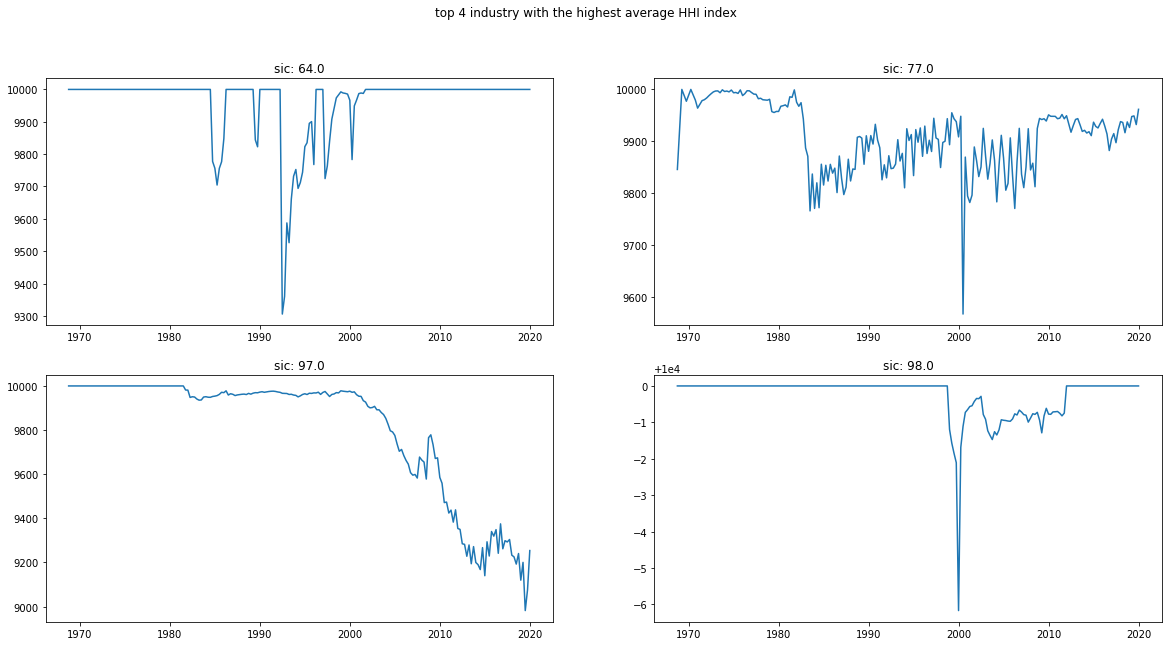

In [218]:
plt.rcParams["figure.figsize"] = (20,10)
fig = plt.figure()
fig.suptitle("top 4 industry with the highest average HHI index")
ax1 = fig.add_subplot(2, 2, 1)
ax1.set_title("sic: "+str(time_data.columns[0]))
ax2 = fig.add_subplot(2, 2, 2)
ax2.set_title("sic: "+str(time_data.columns[1]))
ax3 = fig.add_subplot(2, 2, 3)
ax3.set_title("sic: "+str(time_data.columns[2]))
ax4 = fig.add_subplot(2, 2, 4)
ax4.set_title("sic: "+str(time_data.columns[3]))

ax1.plot(time_data.index, time_data.iloc[:,0])
ax2.plot(time_data.index, time_data.iloc[:,1])
ax3.plot(time_data.index, time_data.iloc[:,2])
ax4.plot(time_data.index, time_data.iloc[:,3])